In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss

Using TensorFlow backend.


In [2]:
basedir = '../Datasets/cartoon_set'
images_dir = os.path.join(basedir,'img')
labels_filename = 'labels.csv'

image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
target_size = (64,64)
labels_file = open(os.path.join(basedir, labels_filename), 'r')
lines = labels_file.readlines()
color_labels = {line.split()[3] : int(line.split()[1]) for line in lines[1:]}
if os.path.isdir(images_dir):
    all_images = []
    all_labels = []
    for img_path in image_paths:
        file_name= img_path.split('..')[1].split('/')[-1]

        # load image
        img = image.img_to_array(
            image.load_img(img_path,
                           target_size=target_size,
                           interpolation='bicubic'))
        all_images.append(img)
        all_labels.append(color_labels[file_name])

images = np.array(all_images)
color_labels = (np.array(all_labels))


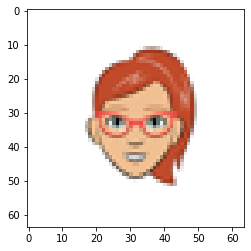

In [3]:
plt.imshow(images[0]/255)
plt.show()

In [4]:
norm_images=images.reshape(images.shape[0],images.shape[1]*images.shape[2]*images.shape[3])/255

In [5]:
norm_images.shape

(10000, 12288)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(norm_images, color_labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_val.shape[3])

# X_val = X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2]*X_val.shape[3])
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_val.shape[3])

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(6000, 12288)
(6000,)
(2000, 12288)
(2000,)
(2000, 12288)
(2000,)


In [8]:
def trainRandomForest(training_images, training_labels, test_images, test_labels, max_depth=None):
    """
    Train the classifier using the appropriate hyperparameters, fit it to the training labels, 
    and output the predictions and class probabilities
    """
    classifier = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=1, max_features='auto')
    classifier.fit(training_images, training_labels)
    pred_prob = classifier.predict_proba(test_images)
    pred = classifier.predict(test_images)
    
    return pred, pred_prob

In [9]:
def crossValidation(X_train, y_train, X_val, y_val):
    """
    Manually train the classifier using different depth values, plot the graph of Error vs depth to observe
    the differences and return the depth with the lowest error
    """
    depth_vec = np.array([None, 1, 3, 10, 30])
    
    error_train = np.zeros(len(depth_vec))
    error_val = np.zeros(len(depth_vec))
    
    for i in range(len(depth_vec)):
        depth = depth_vec[i]
        y_train_pred = trainRandomForest(X_train, y_train, X_train, y_train, depth)[1]
        y_val_pred = trainRandomForest(X_train, y_train, X_val, y_val, depth)[1]

        error_train[i] = log_loss(y_train, y_train_pred, labels=[0, 1, 2, 3, 4])
        error_val[i] = log_loss(y_val, y_val_pred, labels=[0, 1, 2, 3, 4])

    print('Training Error:', error_train)
    print('Validation Error:', error_val)

    minErrorIndex = np.argmin(error_val)
    minError = np.amin(error_val)
    print('Min Validation Error Value:', minError)
    print('Ideal Depth:', depth_vec[minErrorIndex])
    
    plt.plot(depth_vec, error_train, label='Train')
    plt.plot(depth_vec, error_val, label='Cross Validation')
    plt.legend()
    plt.xlabel('Max Depth')
    plt.ylabel('Error')
    plt.title('Validation Curve')
    plt.show()    
        
    return depth_vec[minErrorIndex], minError

In [10]:
def learningCurve(X_train, y_train, X_val, y_val, max_depth):
    """
    Plot the learning curve of the training and validation set errors over number of training examples
    """
        m = X_train.shape[0]
        error_train = np.zeros(int(m/500))
        error_val = np.zeros(int(m/500))
        
        for i in range(500, m+1, 500):
            y_train_pred = trainRandomForest(X_train[0:i], y_train[0:i], X_train[0:i], y_train[0:i], max_depth)[1]
            y_val_pred = trainRandomForest(X_train[0:i], y_train[0:i], X_val, y_val, max_depth)[1]
            
            error_train[int((i-500)/500)] = log_loss(y_train[0:i], y_train_pred, labels=[0, 1, 2, 3, 4])
            error_val[int((i-500)/500)] = log_loss(y_val, y_val_pred, labels=[0, 1, 2, 3, 4])
            
        plt.plot(np.arange(500, m+1, 500), error_train, label='Train')
        plt.plot(np.arange(500, m+1, 500), error_val, label='Cross Validation')
        plt.legend()
        plt.xlabel('Number of Training Examples')
        plt.ylabel('Error')
        plt.title('Learning Curve')
        plt.show()
        
        return None

Training Error: [0.10871306 1.40055151 1.03880801 0.36072939 0.10958546]
Validation Error: [0.44853329 1.39899008 1.04016812 0.50375466 0.45119583]
Min Validation Error Value: 0.44853328753656413
Ideal Depth: None


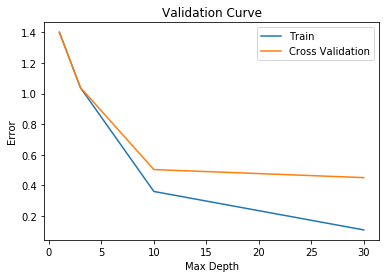

In [11]:
idealDepth = crossValidation(X_train, y_train, X_val, y_val)[0]

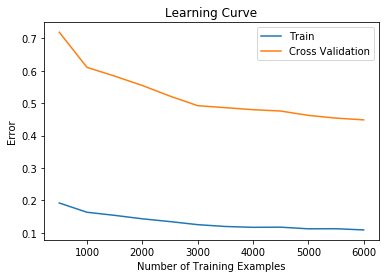

In [12]:
learningCurve(X_train, y_train, X_val, y_val, idealDepth)

In [13]:
pred_train=trainRandomForest(X_train, y_train, X_train, y_train, idealDepth)[0]
print('Accuracy:', accuracy_score(y_train, pred_train))
print(classification_report(y_train, pred_train))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1187
           1       1.00      1.00      1.00      1179
           2       1.00      1.00      1.00      1195
           3       1.00      1.00      1.00      1228
           4       1.00      1.00      1.00      1211

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [14]:
pred_val=trainRandomForest(X_train, y_train, X_val, y_val, idealDepth)[0]
print('Accuracy:', accuracy_score(y_val, pred_val))
print(classification_report(y_val, pred_val))

Accuracy: 0.838
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       405
           1       0.90      0.83      0.86       428
           2       0.83      0.83      0.83       381
           3       0.84      0.84      0.84       377
           4       0.83      0.87      0.85       409

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [15]:
%time pred_test=trainRandomForest(X_train, y_train, X_test, y_test)[0]
print('Accuracy:', accuracy_score(y_test, pred_test))
print(classification_report(y_test, pred_test))

CPU times: user 12 s, sys: 28.1 ms, total: 12 s
Wall time: 12 s
Accuracy: 0.837
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       412
           1       0.90      0.80      0.85       411
           2       0.80      0.83      0.82       393
           3       0.82      0.82      0.82       387
           4       0.84      0.85      0.85       397

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [16]:
basedir = '../Datasets/cartoon_set_test'
images_dir = os.path.join(basedir,'img')
labels_filename = 'labels.csv'

image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
target_size = (64,64)
labels_file = open(os.path.join(basedir, labels_filename), 'r')
lines = labels_file.readlines()
color_labels = {line.split()[3] : int(line.split()[1]) for line in lines[1:]}
if os.path.isdir(images_dir):
    all_images = []
    all_labels = []
    for img_path in image_paths:
        file_name= img_path.split('..')[1].split('/')[-1]

        # load image
        img = image.img_to_array(
            image.load_img(img_path,
                           target_size=target_size,
                           interpolation='bicubic'))
        all_images.append(img)
        all_labels.append(color_labels[file_name])

images = np.array(all_images)
color_labels = (np.array(all_labels))

In [17]:
norm_images=images.reshape(images.shape[0],images.shape[1]*images.shape[2]*images.shape[3])/255

In [18]:
norm_images.shape

(2500, 12288)

In [19]:
X_test_new=norm_images
y_test_new=color_labels

In [20]:
print(X_test_new.shape)
print(y_test_new.shape)

(2500, 12288)
(2500,)


In [21]:
%time pred_test_new=trainRandomForest(X_train, y_train, X_test_new, y_test_new, idealDepth)[0]
print('Accuracy:', accuracy_score(y_test_new, pred_test_new))
print(classification_report(y_test_new, pred_test_new))

CPU times: user 12 s, sys: 28.2 ms, total: 12 s
Wall time: 12 s
Accuracy: 0.8344
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       506
           1       0.87      0.82      0.84       483
           2       0.82      0.84      0.83       525
           3       0.83      0.83      0.83       514
           4       0.84      0.85      0.84       472

    accuracy                           0.83      2500
   macro avg       0.84      0.83      0.83      2500
weighted avg       0.83      0.83      0.83      2500



In [22]:
X_train_join=np.concatenate((X_train,X_val), axis=0)
y_train_join=np.concatenate((y_train,y_val), axis=0)

In [23]:
print(X_train_join.shape)
print(y_train_join.shape)

(8000, 12288)
(8000,)


In [24]:
%time pred_test_join=trainRandomForest(X_train_join, y_train_join, X_test, y_test)[0]
print('Accuracy:', accuracy_score(y_test, pred_test_join))
print(classification_report(y_test, pred_test_join))

CPU times: user 17.2 s, sys: 80.9 ms, total: 17.2 s
Wall time: 17.2 s
Accuracy: 0.841
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       412
           1       0.89      0.80      0.84       411
           2       0.85      0.83      0.84       393
           3       0.83      0.83      0.83       387
           4       0.82      0.86      0.84       397

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [25]:
%time pred_test_new_join=trainRandomForest(X_train_join, y_train_join, X_test_new, y_test_new, idealDepth)[0]
print('Accuracy:', accuracy_score(y_test_new, pred_test_new_join))
print(classification_report(y_test_new, pred_test_new_join))

CPU times: user 16.2 s, sys: 30.2 ms, total: 16.2 s
Wall time: 16.2 s
Accuracy: 0.8388
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       506
           1       0.88      0.82      0.85       483
           2       0.83      0.84      0.83       525
           3       0.83      0.83      0.83       514
           4       0.83      0.87      0.85       472

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500

